# Import

In [ ]:
import os
import glob
import shutil
import random
import tensorflow as tf
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from os import listdir
from os.path import join
from random import shuffle
from numpy.core.records import array
from zipfile import ZipFile
from google.colab import drive
from xml.etree import ElementTree as ET
from PIL import Image
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

%matplotlib inline

# Get dataset

In [ ]:
shutil.copy("/content/drive/MyDrive/kaggle.json", "/content")

'/content/kaggle.json'

In [ ]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 98% 325M/330M [00:06<00:00, 56.1MB/s]
100% 330M/330M [00:06<00:00, 53.7MB/s]


In [ ]:
def unpack_dataset(path:str, folder:str):
  """
  This function get path to zip and unpack it
  """
  zip = ZipFile(path)
  zip.extractall(folder)

In [ ]:
unpack_dataset("/content/face-mask-12k-images-dataset.zip", "12k_images")

# Create dataset classes
Time to define image generator and split dataset

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(directory="/content/12k_images/Face Mask Dataset/Train",
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode="categorical")

Found 10000 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(directory="/content/12k_images/Face Mask Dataset/Test",
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode="categorical")

Found 992 images belonging to 2 classes.


In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(directory="/content/12k_images/Face Mask Dataset/Validation",
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode="categorical")

Found 800 images belonging to 2 classes.


# Create models
Well, we have a lot of images of people in mask and without it. Now we should define some functions about our future models.


In [ ]:
# conv
CONV_FILTERS = [64, 128, 256]
CONV_KERNELS = [3, 3, 3]
CONV_STRIDES = [1, 1, 1]
CONV_PADDING = "same"

# dense
NEURONS = [128]
USE_DROPOUT = [0]

ACTIVATION = "relu"

In [ ]:
def get_conv_model(input_shape,
                   output_shape,
                   conv_filters,
                   conv_kernels,
                   conv_strides,
                   conv_padding,
                   dense_neurons,
                   use_dropout,
                   activation="relu"
                   ):
  """
  Get a CNN
  """
  input_model = Input(shape=input_shape)
  x = input_model
  
  for i in range(len(conv_filters)):
    x = Conv2D(filters      = conv_filters[i],
               kernel_size  = conv_kernels[i],
               strides      = conv_strides[i],
               padding      = conv_padding,
               activation   = activation,
               name="conv_layer_" + str(i))(x)
    
    x = MaxPooling2D(name="max_pooling_layer_" + str(i))(x)
  
  # make a vector
  x = Flatten()(x)
  
  for i in range(len(dense_neurons)):
    x = Dense(units         = dense_neurons[i],
              activation    = activation,
              name          = "dense_layer_" + str(i))(x)
    if (use_dropout[i]):
      x = Dropout(use_dropout[i])(x)
  
  output_model = Dense(output_shape, activation="softmax")(x)
  model = Model(input_model, output_model)
  
  return model

def transfer_to_MobileNetV2(output):
  """
  Get model
  """
  mobilenet = MobileNetV2(weights = "imagenet",include_top = False,input_shape=(150,150,3))

  for layer in mobilenet.layers:
    layer.trainable = False

  
  model = Sequential()
  model.add(mobilenet)
  model.add(GlobalAveragePooling2D())
  model.add(Flatten())
  model.add(Dense(300, activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(100,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2,activation="softmax"))

  return model

In [ ]:
model_CNN = get_conv_model((150, 150, 3),
                           2,
                           CONV_FILTERS,
                           CONV_KERNELS,
                           CONV_STRIDES,
                           CONV_PADDING,
                           NEURONS,
                           USE_DROPOUT)

In [ ]:
model_CNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv_layer_0 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 max_pooling_layer_0 (MaxPoo  (None, 75, 75, 64)       0         
 ling2D)                                                         
                                                                 
 conv_layer_1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 max_pooling_layer_1 (MaxPoo  (None, 37, 37, 128)      0         
 ling2D)                                                         
                                                                 
 conv_layer_2 (Conv2D)       (None, 37, 37, 256)       295168

Our model have a lot of weights

In [ ]:
model_CNN.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

# Fit conv model

In [ ]:
history = model_CNN.fit(train_generator,
                        epochs=5,
                        validation_data=valid_generator)

Epoch 1/5
313/313 [==============================] - 43s 104ms/step - loss: 0.1774 - accuracy: 0.9345 - val_loss: 0.0604 - val_accuracy: 0.9812
Epoch 2/5
313/313 [==============================] - 34s 107ms/step - loss: 0.0656 - accuracy: 0.9756 - val_loss: 0.0337 - val_accuracy: 0.9875
Epoch 3/5
313/313 [==============================] - 31s 100ms/step - loss: 0.0380 - accuracy: 0.9875 - val_loss: 0.0358 - val_accuracy: 0.9850
Epoch 4/5
313/313 [==============================] - 31s 99ms/step - loss: 0.0291 - accuracy: 0.9900 - val_loss: 0.0187 - val_accuracy: 0.9900
Epoch 5/5
313/313 [==============================] - 31s 99ms/step - loss: 0.0213 - accuracy: 0.9919 - val_loss: 0.0155 - val_accuracy: 0.9925


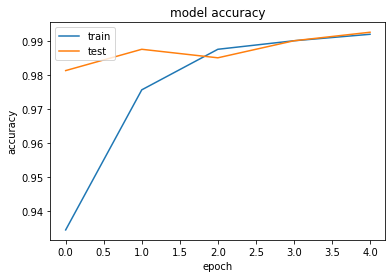

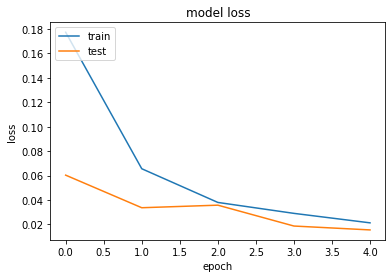

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_CNN.evaluate(test_generator)

31/31 [==============================] - 2s 63ms/step - loss: 0.0236 - accuracy: 0.9919


[0.023640817031264305, 0.9919354915618896]

In [ ]:
model_CNN.save("model_CNN.h5")

# Transfer learning on MobileNetV2

In [ ]:
model = transfer_to_MobileNetV2(2)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 300)               384300    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               3

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics ="accuracy")

In [ ]:
model.fit(train_generator, epochs=3, validation_data=valid_generator)

Epoch 1/3
313/313 [==============================] - 29s 80ms/step - loss: 0.1082 - accuracy: 0.9629 - val_loss: 0.0439 - val_accuracy: 0.9812
Epoch 2/3
313/313 [==============================] - 23s 75ms/step - loss: 0.0484 - accuracy: 0.9854 - val_loss: 0.0271 - val_accuracy: 0.9912
Epoch 3/3
313/313 [==============================] - 23s 74ms/step - loss: 0.0282 - accuracy: 0.9908 - val_loss: 0.0142 - val_accuracy: 0.9950


In [ ]:
model.evaluate(test_generator)

31/31 [==============================] - 2s 68ms/step - loss: 0.0159 - accuracy: 0.9950


[0.015881789848208427, 0.9949596524238586]

In [ ]:
model.save("mask_recog.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Summary 

And now see how it work

In [ ]:
!kaggle datasets download -d andrewmvd/face-mask-detection

 97% 384M/398M [00:02<00:00, 187MB/s]
100% 398M/398M [00:02<00:00, 182MB/s]


In [ ]:
!kaggle datasets download -d lalitharajesh/haarcascades

  0% 0.00/1.45M [00:00<?, ?B/s]
100% 1.45M/1.45M [00:00<00:00, 48.8MB/s]


In [ ]:
unpack_dataset("/content/face-mask-detection.zip", "testing")

In [ ]:
unpack_dataset("/content/haarcascades.zip", "haarcascades")

In [ ]:
def locata_and_recognize(path_to_image):
  face_cascade = cv2.CascadeClassifier("/content/haarcascades/haarcascade_frontalface_default.xml")

  img = cv2.imread(path_to_image)
  img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
  faces = face_cascade.detectMultiScale(img, scaleFactor=1.05, minNeighbors=5)
  new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

  for i in range(len(faces)):
    (x,y,w,h) = faces[i]
    cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),1)
    crop = new_img[y:y+h,x:x+w]
    crop = cv2.resize(crop,(150,150))
    crop = np.reshape(crop,[1,150,150,3]) / 255
    mask_result = model.predict(crop)
    if np.argmax(mask_result) == 0:
      print("With mask")
    elif np.argmax(mask_result) == 1:
      print("No mask")
  plt.imshow(new_img)

With mask
With mask
With mask


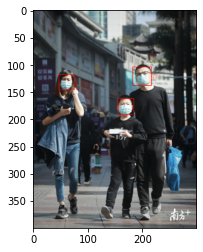

In [ ]:
locata_and_recognize(join("/content/testing/images", random.choice(listdir("/content/testing/images"))))